# **Music Recommendation System**

### **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

### **Loading Dataset**

In [2]:
tracks = pd.read_csv('/Users/jes/Downloads/Music Recommendation System/tracks_transformed.csv')
tracks.head()

,id,name,artists,id_artists,genres,release_year,duration_s,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,35iwgR4jXetI318WEWsa1Q,Carve,Uli,['45tIt06XoI0Iio4LBEVpls'],NaN,1922,126.903,6,0.645,0.4450,0,46.662,1,0.4510,0.674,0.7440,0.151,0.127,104.851
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,Fernando Pessoa,['14jtPCOoNZwquk5wd9DxrY'],NaN,1922,98.200,0,0.695,0.2630,0,37.864,1,0.9570,0.797,0.0000,0.148,0.655,102.009
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,Ignacio Corsini,['5LiOoJbxVSAMkBS2fUm3X2'],tango vintage tango,1922,181.640,0,0.434,0.1770,1,38.820,1,0.0512,0.994,0.0218,0.212,0.457,130.418
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,Ignacio Corsini,['5LiOoJbxVSAMkBS2fUm3X2'],tango vintage tango,1922,176.907,0,0.321,0.0946,7,32.039,1,0.0504,0.995,0.9180,0.104,0.397,169.980
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,Dick Haymes,['3BiJGZsyX9sJchTqcSA7Su'],adult standards big band easy listening lounge...,1922,163.080,0,0.402,0.1580,3,43.100,0,0.0390,0.989,0.1300,0.311,0.196,103.220


In [3]:
tracks.columns

Index(['id', 'name', 'artists', 'id_artists', 'genres', 'release_year',
       'duration_s', 'popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo'],
      dtype='object')

In [4]:
tracks.shape

(586672, 19)

In [5]:
tracks.isnull().sum()

id                      0
name                   71
artists                71
id_artists              0
genres              49825
release_year            0
duration_s              0
popularity              0
danceability            0
energy                  0
key                     0
loudness                0
mode                    0
speechiness             0
acousticness            0
instrumentalness        0
liveness                0
valence                 0
tempo                   0
dtype: int64

In [6]:
tracks.dropna(inplace = True)

In [7]:
tracks = tracks.drop(['id', 'id_artists'], axis = 1)

### **Exploratory Data Analysis**

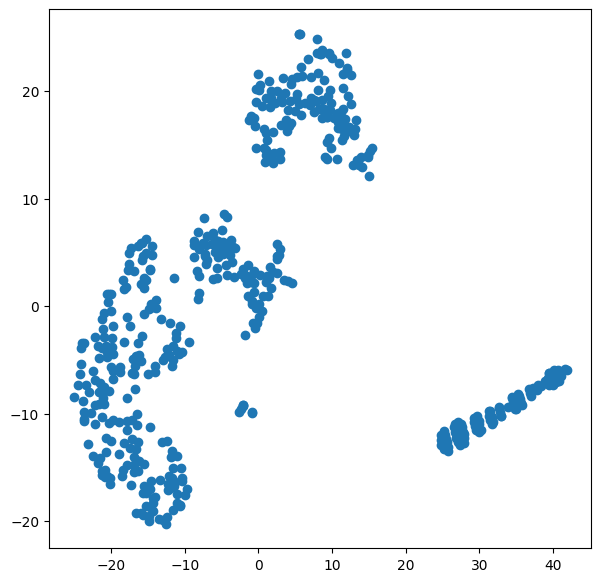

In [8]:
# Select only numeric columns for t-SNE (adjust columns as needed)
numeric_features = tracks[['popularity', 'danceability', 'energy']]  # Add or adjust features as needed

# Initialize and fit-transform with t-SNE
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(numeric_features.head(500))  # Use a subset if the dataset is large

# Plot the 2D t-SNE result
plt.figure(figsize=(7, 7))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
plt.show()


In [9]:
tracks['name'].nunique(), tracks.shape

(408902, (536847, 17))

In [10]:
tracks = tracks.sort_values(by=['popularity'], ascending=False)
tracks.drop_duplicates(subset=['name'], keep='first', inplace=True)

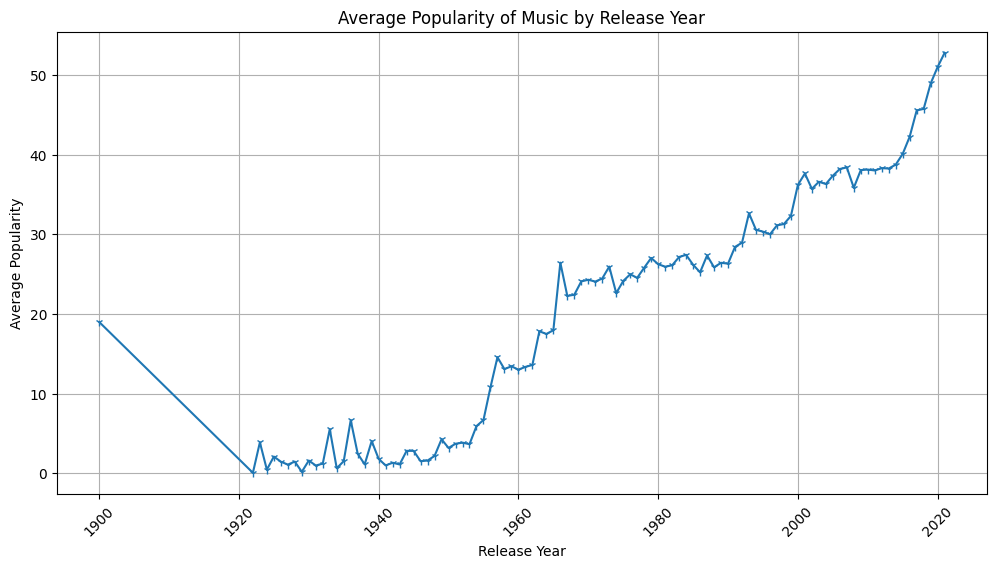

In [23]:
# Calculate the average popularity for each release year
avg_popularity = tracks.groupby('release_year')['popularity'].mean().reset_index()

# Plot the average popularity by release year
plt.figure(figsize=(12, 6))
plt.plot(avg_popularity['release_year'], avg_popularity['popularity'], marker='1')
plt.title('Average Popularity of Music by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Average Popularity')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()  # Optional: Add a grid for easier reading
plt.show()


In [25]:
floats = []
for col in tracks.columns:
  if tracks[col].dtype == 'float':
    floats.append(col)
 
len(floats)

10

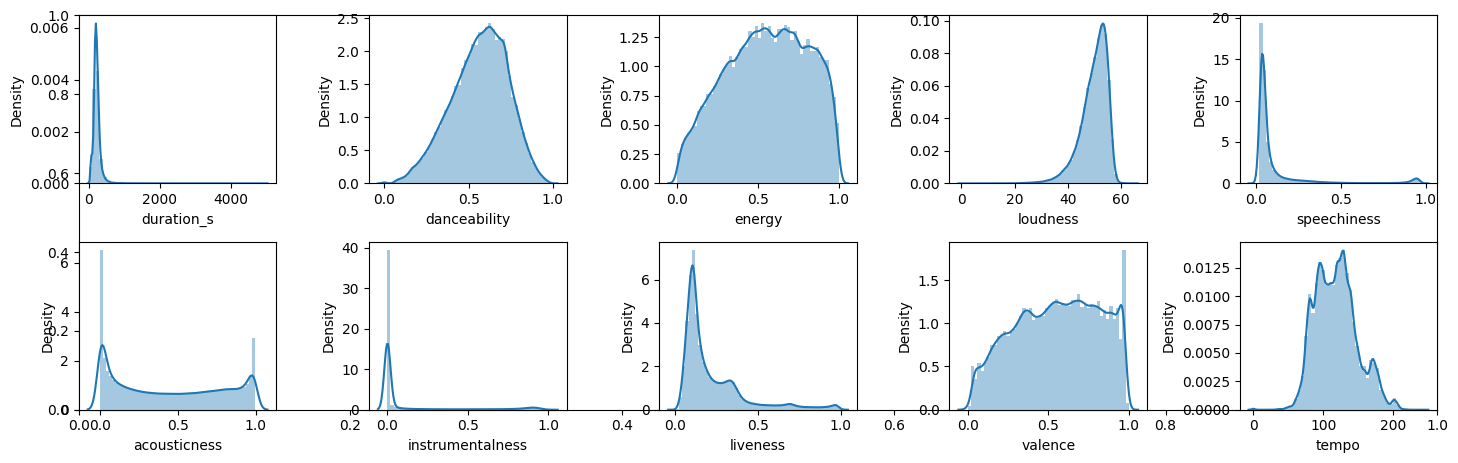

In [26]:
plt.subplots(figsize = (15, 5))
for i, col in enumerate(floats):
  plt.subplot(2, 5, i + 1)
  sb.distplot(tracks[col])
plt.tight_layout()
plt.show()

### **Recommendation System**

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Load and preprocess data (assuming you've done this)
tracks = pd.read_csv('/Users/jes/Downloads/Music Recommendation System/tracks_transformed.csv')
tracks.dropna(inplace=True)
tracks = tracks.drop(['id', 'id_artists'], axis=1)

# Fit the CountVectorizer on genres
song_vectorizer = CountVectorizer()
song_vectorizer.fit(tracks['genres'])

# Sort the tracks by popularity
tracks = tracks.sort_values(by=['popularity'], ascending=False).head(10000)

def get_similarities(song_name, data):
    # Getting vector for the input song.
    text_array1 = song_vectorizer.transform(data[data['name'] == song_name]['genres']).toarray()
    num_array1 = data[data['name'] == song_name].select_dtypes(include=np.number).to_numpy()

    # We will store similarity for each row of the dataset.
    sim = []
    for idx, row in data.iterrows():
        name = row['name']
        
        # Getting vector for current song.
        text_array2 = song_vectorizer.transform(data[data['name'] == name]['genres']).toarray()
        num_array2 = data[data['name'] == name].select_dtypes(include=np.number).to_numpy()

        # Calculating similarities for text as well as numeric features
        text_sim = cosine_similarity(text_array1, text_array2)[0][0]
        num_sim = cosine_similarity(num_array1, num_array2)[0][0]
        sim.append(text_sim + num_sim)
        
    return sim

def recommend_songs(song_name, data=tracks):
    # Base case: Check if the input song exists in the dataset
    if data[data['name'] == song_name].shape[0] == 0:
        print('This song is either not so popular or you have entered an invalid name.\nSome songs you may like:\n')
        for song in data.sample(n=5)['name'].values:
            print(song)
        return

    # Calculate similarity factors
    data['similarity_factor'] = get_similarities(song_name, data)

    # Sort based on similarity and popularity
    data.sort_values(by=['similarity_factor', 'popularity'], ascending=[False, False], inplace=True)

    # Drop duplicates based on the song names
    unique_recommendations = data[['name', 'artists']].drop_duplicates(subset=['name'])

    # Display recommended songs, skip the input song itself
    print("Recommended songs based on your input:")
    display(unique_recommendations[unique_recommendations['name'] != song_name].head(5))  # Show top 5 recommendations


In [58]:
recommend_songs('Shape of You')

Recommended songs based on your input:


,name,artists
119410,I Don't Care - Acoustic,Ed Sheeran
90082,Supermarket Flowers,Ed Sheeran
91939,Bruises,Lewis Capaldi
91899,Before You Go,Lewis Capaldi
90741,What Do I Know?,Ed Sheeran


In [59]:
recommend_songs('Love Someone')

Recommended songs based on your input:


,name,artists
88968,7 Years,Lukas Graham
89647,Mama Said,Lukas Graham
75563,Move Your Feet,Junior Senior
83167,Moves Like Jagger - Studio Recording From The ...,"Maroon 5, Christina Aguilera"
93171,motive (with Doja Cat),"Ariana Grande, Doja Cat"


In [87]:
recommend_songs('Starboy')

Recommended songs based on your input:


,name,artists
88950,I Feel It Coming,"The Weeknd, Daft Punk"
89392,False Alarm,The Weeknd
88195,In The Night,The Weeknd
89158,Reminder,The Weeknd
92813,Blinding Lights,The Weeknd
